In [ ]:
!pip install ultralytics numpy pandas opencv-python matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
import zipfile
import os
import yaml

# 1. Unzip the dataset
dataset_zip = "/content/drive/MyDrive/brain tumor/archive.zip"
extract_path = "/content/Brain_Tumor_MRI_Dataset"

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzip complete!")

Unzip complete!


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

class BrainTumorDetector:
    def __init__(self, model_path=None, pretrained=True):
        if model_path:
            self.model = YOLO(model_path)
        else:
            self.model = YOLO('yolov8n.pt' if pretrained else 'yolov8n.yaml')

    def train(self, data_yaml, epochs=50, imgsz=640, batch=16, **kwargs):
        results = self.model.train(
            data=data_yaml,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch,
            name='yolov8n_brain_tumor',
            **kwargs
        )
        return results

    def predict(self, image_path, conf=0.5, iou=0.5, show=False, save=True):

        results = self.model.predict(
            source=image_path,
            conf=conf,
            iou=iou,
            show=show,
            save=save
        )
        return results

    def evaluate(self, data_yaml, batch=16, imgsz=640):

        metrics = self.model.val(
            data=data_yaml,
            batch=batch,
            imgsz=imgsz
        )
        return metrics

    def visualize_detection(self, image_path, conf=0.5):
        # Load and predict
        img = cv2.imread(image_path)
        results = self.predict(image_path, conf=conf, show=False, save=False)

        # Plot
        plt.figure(figsize=(10, 10))

        # Draw bounding boxes
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            confidences = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()

            for box, conf, cls in zip(boxes, confidences, classes):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"Tumor: {conf:.2f}"
                cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 1. Create proper directory structure
dataset_path = "/content/Brain_Tumor_MRI_Dataset/Training"
yolo_path = "/content/yolo_dataset"

os.makedirs(yolo_path, exist_ok=True)
for folder in ['images/train', 'images/val', 'images/test',
              'labels/train', 'labels/val', 'labels/test']:
    os.makedirs(os.path.join(yolo_path, folder), exist_ok=True)

# 2. Process images and create annotations
class_mapping = {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3}

for class_name, class_id in class_mapping.items():
    class_dir = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

    # Split dataset
    train, test = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)

    for split, split_name in zip([train, val, test], ['train', 'val', 'test']):
        for img in split:

            src = os.path.join(class_dir, img)
            dst = os.path.join(yolo_path, f'images/{split_name}', img)
            shutil.copy(src, dst)


            annotation_path = os.path.join(yolo_path, f'labels/{split_name}',
                                         os.path.splitext(img)[0] + '.txt')
            with open(annotation_path, 'w') as f:
                f.write(f"{class_id} 0.5 0.5 0.9 0.9\n")

# 3. Create the YAML file
yaml_content = f"""path: {yolo_path}
train: images/train
val: images/val
test: images/test

nc: 4

names:
  0: glioma
  1: meningioma
  2: notumor
  3: pituitary
"""

with open(os.path.join(yolo_path, 'brain_tumor.yaml'), 'w') as f:
    f.write(yaml_content)

print("Dataset preparation complete!")

Dataset preparation complete!


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # load pretrained model
results = model.train(
    data='/content/yolo_dataset/brain_tumor.yaml',
    epochs=60,
    imgsz=640,
    batch=16,
    name='brain_tumor_detection'
)
# Explicitly save the model
model.save('brain_tumor_detection_final.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 95.0MB/s]


Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/brain_tumor.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

100%|██████████| 755k/755k [00:00<00:00, 25.5MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 90.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 803.3±359.2 MB/s, size: 24.1 KB)


train: Scanning /content/yolo_dataset/labels/train... 3996 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3996/3996 [00:01<00:00, 2560.40it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 385.9±147.1 MB/s, size: 21.8 KB)


val: Scanning /content/yolo_dataset/labels/val... 857 images, 0 backgrounds, 0 corrupt: 100%|██████████| 857/857 [00:00<00:00, 1285.39it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/brain_tumor_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/brain_tumor_detection
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.02G     0.6401      1.736      1.276         36        640: 100%|██████████| 250/250 [01:11<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


                   all        857        857      0.688      0.808       0.84      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.76G     0.4214     0.9797      1.069         42        640: 100%|██████████| 250/250 [01:08<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


                   all        857        857      0.655      0.709      0.645      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.78G     0.3968     0.8114      1.048         32        640: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


                   all        857        857      0.799      0.485      0.727      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.79G     0.3638     0.7236      1.027         34        640: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.09it/s]


                   all        857        857      0.916      0.891      0.975      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       2.8G     0.3257     0.6402      1.002         40        640: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.67it/s]

                   all        857        857       0.93      0.925      0.975      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.82G     0.3127     0.6171      0.994         34        640: 100%|██████████| 250/250 [01:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


                   all        857        857      0.278      0.947      0.541      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.84G     0.2868     0.5868      0.979         35        640: 100%|██████████| 250/250 [01:08<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.82it/s]

                   all        857        857      0.863      0.875      0.973      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.86G     0.2909     0.5508     0.9845         38        640: 100%|██████████| 250/250 [01:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.23it/s]

                   all        857        857      0.915       0.91      0.978      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.87G     0.2678     0.5213     0.9683         29        640: 100%|██████████| 250/250 [01:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.29it/s]

                   all        857        857      0.876       0.92      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.89G     0.2583     0.4989     0.9627         35        640: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.61it/s]

                   all        857        857      0.949      0.964      0.985      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.91G     0.2515     0.5031      0.963         36        640: 100%|██████████| 250/250 [01:07<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]

                   all        857        857      0.817      0.825      0.956      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.93G     0.2393     0.4844     0.9542         40        640: 100%|██████████| 250/250 [01:08<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.06it/s]

                   all        857        857      0.931      0.944      0.982      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.94G     0.2293      0.476     0.9455         40        640: 100%|██████████| 250/250 [01:12<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]

                   all        857        857      0.934      0.947      0.982       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.96G     0.2251     0.4325     0.9484         37        640: 100%|██████████| 250/250 [01:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.69it/s]

                   all        857        857      0.908      0.955      0.982       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.98G     0.2247     0.4369     0.9466         35        640: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.34it/s]

                   all        857        857      0.909      0.944      0.982      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.99G     0.2257     0.4218     0.9473         34        640: 100%|██████████| 250/250 [01:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.28it/s]

                   all        857        857      0.949      0.955      0.984      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.01G     0.2199     0.4161     0.9432         40        640: 100%|██████████| 250/250 [01:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]

                   all        857        857      0.897      0.919      0.977      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.03G     0.2126     0.4008     0.9402         32        640: 100%|██████████| 250/250 [01:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.48it/s]

                   all        857        857      0.948      0.942       0.99      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.04G     0.2029     0.3996     0.9369         37        640: 100%|██████████| 250/250 [01:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.92it/s]

                   all        857        857      0.947      0.972      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.06G     0.2029     0.3918     0.9352         31        640: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.33it/s]

                   all        857        857      0.962      0.964       0.99      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.08G     0.1967     0.3803     0.9337         35        640: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.99it/s]

                   all        857        857      0.947      0.957      0.989      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60       3.1G     0.1933     0.3677     0.9351         27        640: 100%|██████████| 250/250 [01:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]

                   all        857        857      0.969      0.963      0.991      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.11G     0.1898     0.3606     0.9337         41        640: 100%|██████████| 250/250 [01:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]

                   all        857        857      0.955      0.959      0.987      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.13G     0.1879     0.3543     0.9325         39        640: 100%|██████████| 250/250 [01:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.19it/s]

                   all        857        857      0.974       0.96      0.991      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.15G     0.1908     0.3641     0.9324         27        640: 100%|██████████| 250/250 [01:09<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.03it/s]

                   all        857        857      0.971      0.945      0.991      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.16G     0.1858     0.3489     0.9278         28        640: 100%|██████████| 250/250 [01:07<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.48it/s]

                   all        857        857      0.952      0.974      0.992      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.18G     0.1812     0.3419      0.924         34        640: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]

                   all        857        857      0.958      0.965      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       3.2G      0.178     0.3454     0.9277         29        640: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.04it/s]

                   all        857        857      0.955      0.953      0.989      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.21G     0.1741      0.341     0.9259         26        640: 100%|██████████| 250/250 [01:06<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.20it/s]

                   all        857        857      0.958      0.947      0.987      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.23G     0.1774     0.3361     0.9235         36        640: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.30it/s]

                   all        857        857      0.975      0.976      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.25G     0.1677     0.3264     0.9223         34        640: 100%|██████████| 250/250 [01:07<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.54it/s]

                   all        857        857      0.975      0.972      0.993      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.27G     0.1703     0.3229     0.9241         34        640: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


                   all        857        857      0.968      0.985      0.993      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.28G      0.165       0.32     0.9203         32        640: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.30it/s]

                   all        857        857      0.966      0.975      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       3.3G     0.1631     0.3154     0.9201         31        640: 100%|██████████| 250/250 [01:06<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.29it/s]

                   all        857        857      0.976      0.968      0.993      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.32G     0.1604     0.3126     0.9141         34        640: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.27it/s]

                   all        857        857      0.982      0.982      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.33G     0.1578     0.3001     0.9149         33        640: 100%|██████████| 250/250 [01:06<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.62it/s]

                   all        857        857      0.985      0.955      0.992      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.35G     0.1606     0.2996     0.9172         40        640: 100%|██████████| 250/250 [01:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.51it/s]

                   all        857        857      0.967      0.977      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.37G     0.1566     0.3005     0.9191         37        640: 100%|██████████| 250/250 [01:07<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.14it/s]

                   all        857        857      0.966      0.973      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.38G     0.1525     0.2983     0.9166         37        640: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.23it/s]

                   all        857        857      0.987      0.987      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60       3.4G     0.1496     0.2932     0.9143         34        640: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.09it/s]

                   all        857        857       0.98      0.984      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.42G     0.1474     0.2845      0.914         41        640: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


                   all        857        857      0.983      0.981      0.993      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.44G     0.1458     0.2716     0.9117         38        640: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.96it/s]

                   all        857        857      0.985      0.989      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.45G     0.1434     0.2758     0.9118         29        640: 100%|██████████| 250/250 [01:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.27it/s]

                   all        857        857       0.98      0.987      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.47G     0.1433     0.2624     0.9119         33        640: 100%|██████████| 250/250 [01:08<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.90it/s]

                   all        857        857       0.97      0.981      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.49G     0.1439     0.2621     0.9097         38        640: 100%|██████████| 250/250 [01:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.54it/s]

                   all        857        857      0.986      0.984      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.51G     0.1403     0.2629     0.9093         34        640: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.92it/s]

                   all        857        857      0.987      0.985      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.52G     0.1361     0.2548     0.9094         36        640: 100%|██████████| 250/250 [01:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.48it/s]

                   all        857        857      0.989      0.985      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.54G     0.1352     0.2608     0.9089         37        640: 100%|██████████| 250/250 [01:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


                   all        857        857       0.99      0.987      0.995      0.995

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.56G     0.1323     0.2571     0.9072         38        640: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.65it/s]

                   all        857        857      0.986      0.993      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.57G     0.1287      0.246     0.9046         39        640: 100%|██████████| 250/250 [01:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.78it/s]


                   all        857        857      0.989      0.989      0.995      0.995
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.59G     0.1265      0.188     0.9419         12        640: 100%|██████████| 250/250 [01:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.27it/s]

                   all        857        857      0.989      0.989      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.61G     0.1095     0.1255     0.9324         12        640: 100%|██████████| 250/250 [01:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.35it/s]

                   all        857        857      0.984      0.983      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.63G     0.1028     0.1173     0.9205         12        640: 100%|██████████| 250/250 [01:03<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.28it/s]

                   all        857        857      0.987      0.983      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.64G    0.09628     0.1081     0.9245         12        640: 100%|██████████| 250/250 [01:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.57it/s]

                   all        857        857      0.981      0.982      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.66G    0.09309     0.1008     0.9167         12        640: 100%|██████████| 250/250 [01:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.31it/s]

                   all        857        857      0.979       0.99      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.68G    0.08784    0.09594     0.9145         12        640: 100%|██████████| 250/250 [01:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


                   all        857        857      0.987      0.987      0.994      0.994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60       3.7G    0.09018    0.09484     0.9163         12        640: 100%|██████████| 250/250 [01:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.75it/s]

                   all        857        857      0.986      0.987      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.71G    0.08525    0.09061     0.9158         12        640: 100%|██████████| 250/250 [01:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.23it/s]

                   all        857        857      0.988      0.985      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.73G     0.0834    0.09062     0.9169         12        640: 100%|██████████| 250/250 [01:06<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.25it/s]

                   all        857        857      0.986       0.99      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.75G    0.08003    0.08486     0.9064         12        640: 100%|██████████| 250/250 [01:05<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.31it/s]

                   all        857        857      0.981      0.991      0.994      0.994



60 epochs completed in 1.235 hours.
Optimizer stripped from runs/detect/brain_tumor_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/brain_tumor_detection/weights/best.pt, 6.2MB

Validating runs/detect/brain_tumor_detection/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


                   all        857        857      0.989      0.989      0.995      0.995
                glioma        198        198      0.994      0.995      0.995      0.995
            meningioma        201        201      0.971      0.998      0.994      0.994
               notumor        239        239      0.992      0.992      0.995      0.995
             pituitary        219        219          1      0.969      0.995      0.995
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/brain_tumor_detection


In [ ]:
# Evaluate model performance on the validation set
metrics = model.val()
print(metrics.box.map)
print(metrics.box.map50)
print(metrics.box.map75)

Ultralytics 8.3.134 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 590.8±191.0 MB/s, size: 21.0 KB)


val: Scanning /content/yolo_dataset/labels/val.cache... 857 images, 0 backgrounds, 0 corrupt: 100%|██████████| 857/857 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]


                   all        857        857      0.955      0.947      0.985      0.982
                glioma        198        198      0.973      0.939      0.988      0.988
            meningioma        201        201      0.922      0.942      0.976      0.976
               notumor        239        239      0.948      0.999      0.992      0.989
             pituitary        219        219      0.975      0.909      0.983      0.974
Speed: 0.7ms preprocess, 5.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/brain_tumor_detection62
0.9818774974070108
0.9850616908446914
0.9850616908446914



image 1/1 /content/yolo_dataset/images/test/Tr-glTr_0006.jpg: 640x640 1 glioma, 12.8ms
Speed: 4.3ms preprocess, 12.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/brain_tumor_detection2


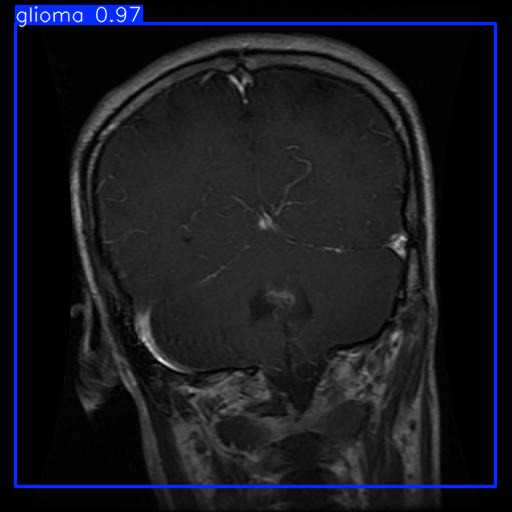

In [ ]:
# Run inference on a test image
results = model.predict('/content/yolo_dataset/images/test/Tr-glTr_0006.jpg', save=True)

# Show results
for result in results:
    boxes = result.boxes
    masks = result.masks
    keypoints = result.keypoints
    probs = result.probs
    result.show()
    result.save(filename='result.jpg')

In [ ]:
brain_tumor_detection_final.pt


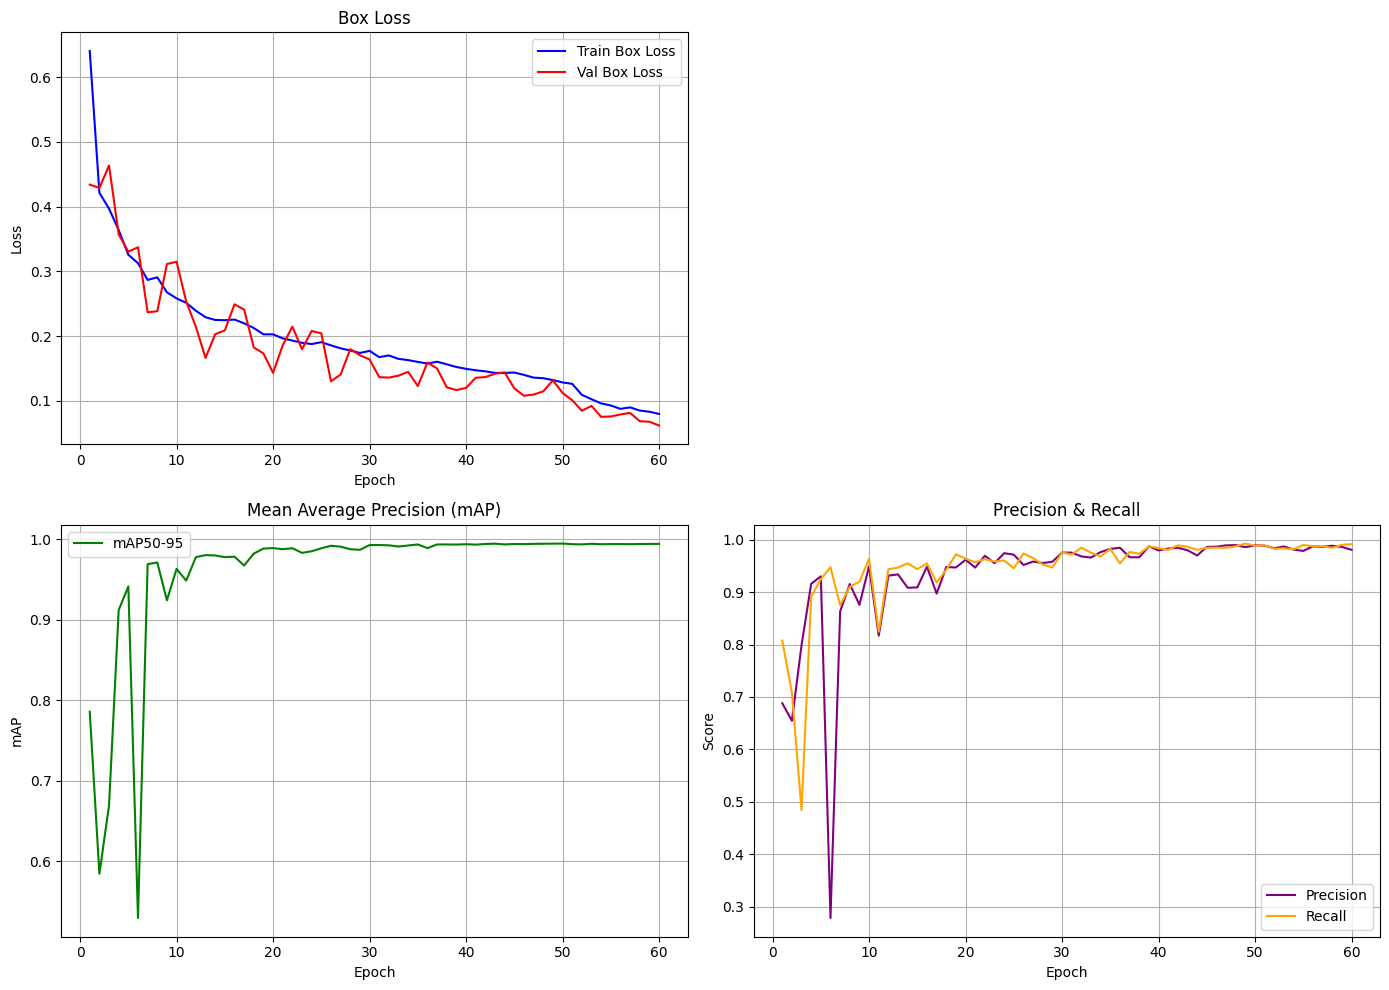

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your results.csv
results_csv = "runs/detect/brain_tumor_detection/results.csv"
df = pd.read_csv(results_csv)
plt.figure(figsize=(14, 10))

# Box Loss
plt.subplot(2, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
plt.title('Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()



# mAP (Detection Accuracy)
plt.subplot(2, 2, 3)
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', color='green')
plt.title('Mean Average Precision (mAP)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid()

# Precision & Recall
plt.subplot(2, 2, 4)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='orange')
plt.title('Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()